# Deriving water balance on irrigated farms using remote sensing images

## This notebook demonstrates how to estimate Actual Evapo-Transpiration (AET) using the [CMRSET methodology](https://www.wateraccounting.org/files/guerschman_j%20_of_hydr.pdf)

#### [Example](https://www.waterconnect.sa.gov.au/Content/Publications/DEW/DEWNR-TN-2016-10.pdf) of application of this methodology:


### 1.- Load datacube environment

In [1]:
import xarray as xr
import numpy as np
from datetime import date, timedelta

import datacube

dc = datacube.Datacube(app="watersense_irrigated")

### 2.- Define location and query parameters

In [2]:
locs = {"Norwood": {"coords": [149.7543738, -29.3741845]},
        "Redbank": {"coords": [150.0313090, -29.4199982]}}

coords = locs["Norwood"]["coords"]

query = {'lat': (coords[1]+0.05, coords[1]-0.05),
         'lon': (coords[0]-0.05, coords[0]+0.05),
         'output_crs': 'EPSG:3577',
         'resolution': (-25, 25),
         'measurements': ['nbart_red', 'nbart_green', 'nbart_blue', 
                          'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'],
         'time':("2020-09-01", "2021-01-01")}

# Scale values between 0-1
ds = dc.load(product='ga_ls8c_ard_3', group_by='solar_day', **query)/10000

ds

<xarray.Dataset>
Dimensions:       (time: 6, x: 443, y: 499)
Coordinates:
  * time          (time) datetime64[ns] 2020-09-03T23:55:03.484048 ... 2020-1...
  * y             (y) float64 -3.305e+06 -3.305e+06 ... -3.318e+06 -3.318e+06
  * x             (x) float64 1.693e+06 1.693e+06 ... 1.704e+06 1.704e+06
    spatial_ref   int32 3577
Data variables:
    nbart_red     (time, y, x) float64 0.0989 0.1016 0.1023 ... 0.1866 0.1836
    nbart_green   (time, y, x) float64 0.0832 0.0841 0.085 ... 0.1411 0.1392
    nbart_blue    (time, y, x) float64 0.0659 0.0663 0.0662 ... 0.0981 0.0967
    nbart_nir     (time, y, x) float64 0.1545 0.1566 0.1574 ... 0.2716 0.2642
    nbart_swir_1  (time, y, x) float64 0.1949 0.2036 0.2096 ... 0.3402 0.3318
    nbart_swir_2  (time, y, x) float64 0.1519 0.1648 0.1718 ... 0.2443 0.2408
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### 3.- Plot the RGB query results

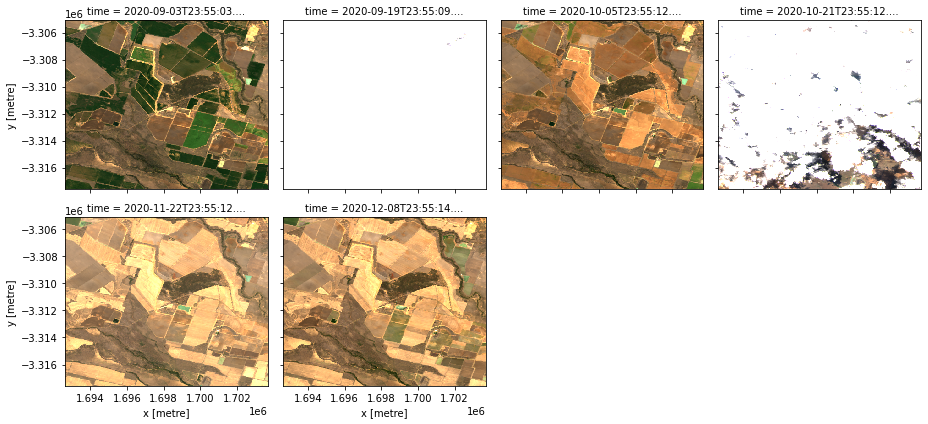

In [3]:
ds[['nbart_red','nbart_green','nbart_blue']].clip(0,0.15).to_array().plot.imshow(col='time', col_wrap=4)

### 4.- Select cloud free samples, one per month, and show results

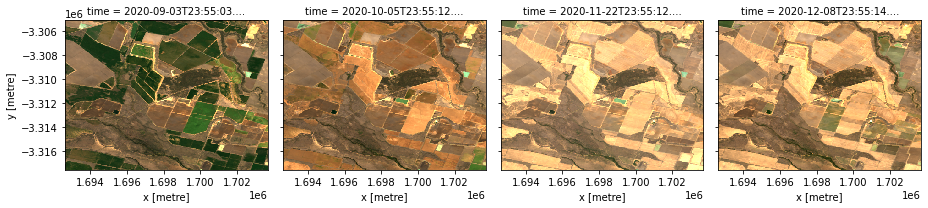

In [4]:
ds = ds.isel(time=[0,2,4,5])

ds[['nbart_red','nbart_green','nbart_blue']].clip(0,0.15).to_array().plot.imshow(col='time', col_wrap=4)

### 5.- Defining our custom functions using DEA data. NDVI Example

##### NDVI = (NIR - RED) / (NIR + RED)

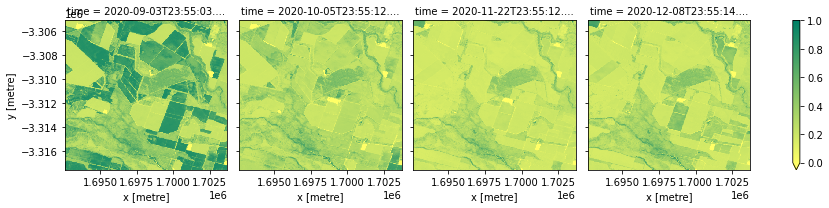

In [5]:
def ndvi(dataset):
    return (dataset.nbart_nir - dataset.nbart_red) / (dataset.nbart_nir + dataset.nbart_red)

ndvi(ds).plot(col='time', col_wrap=4, cmap="summer_r", vmin=0, vmax=1)

#### Do you know what are the bright yellow patches?

### 6.- WOfS dataset

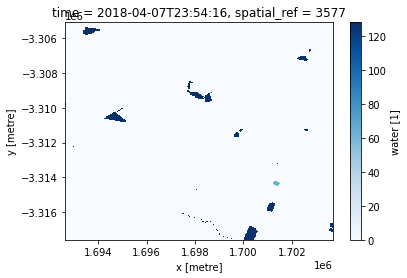

In [6]:
query = {'lat': (coords[1]+0.05, coords[1]-0.05),
         'lon': (coords[0]-0.05, coords[0]+0.05),
         'output_crs': 'EPSG:3577',
         'resolution': (-25, 25),
         'time':("2018-04-01", "2018-04-10")}

ds_wofs = dc.load(product='wofs_albers', **query)

ds_wofs.water.plot(cmap="Blues")

### 7.- Our own version of WOfS with NDVI thresholding

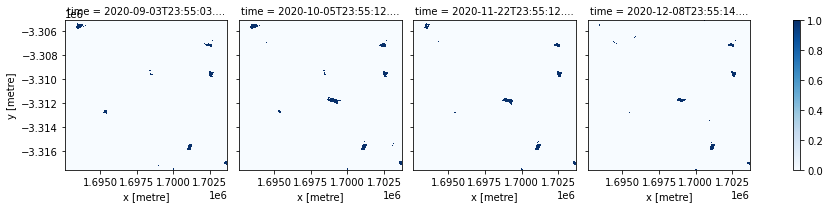

In [7]:
(ndvi(ds)<0).plot(cmap="Blues", col='time', col_wrap=4)

#### Adding all the images together

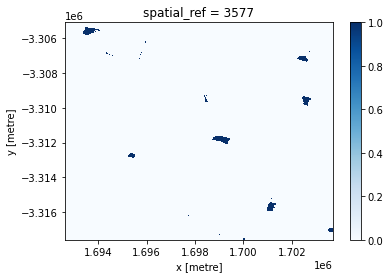

In [8]:
((ndvi(ds)<0).sum(dim="time")>1).plot(cmap="Blues")

### 8.- Enhanced Vegetation Index (EVI) (Huete et al., 2002) and improved version of NDVI

#### While the EVI is calculated similarly to NDVI, it corrects for some distortions in the reflected light caused by the particles in the air as well as the ground cover below the vegetation. The EVI data product also does not become saturated as easily as the NDVI when viewing dense forests.

##### EVI = 2.5 * (NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1)

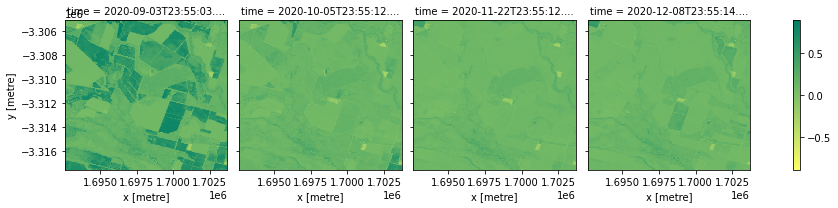

In [9]:
def evi(ds):
    G = 2.5
    C1 = 6
    C2 = 7.5
    L = 1

    return G * (ds.nbart_nir - ds.nbart_red) / (ds.nbart_nir + C1 * ds.nbart_red - C2 * ds.nbart_blue + L)

evi(ds).plot(col='time', col_wrap=4, cmap="summer_r")

### 9.- EVIr a rescaled version of EVI

##### EVIr = min(1, max(0, EVI/0.9 ))

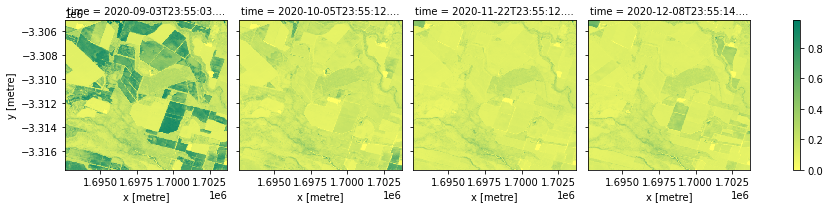

In [10]:
def evir(ds):
    return np.clip(evi(ds)/0.9, 0, 1)

evir(ds).plot(col='time', col_wrap=4, cmap="summer_r")

### 10.- Global Vegetation Moisture Index (GVMI) (Ceccato et al., 2002)

##### GVMI=((NIR+0.1)-(SWIR+0.02)) / ((NIR+0.1)+(SWIR+0.02))

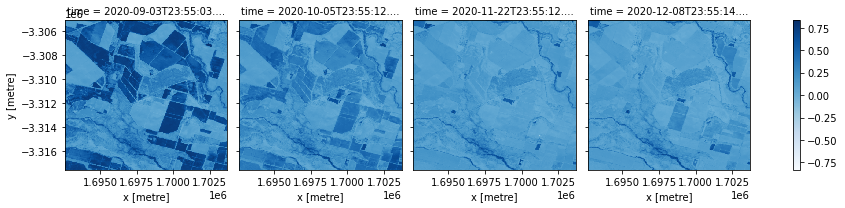

In [11]:
def gvmi(ds):
    return ((ds.nbart_nir + .1) - (ds.nbart_swir_2 + .02)) / ((ds.nbart_nir + .1) + (ds.nbart_swir_2 + .02))

gvmi(ds).plot(col='time', col_wrap=4, cmap="Blues")

### 11.- Residual Moisture Index (RMI)

##### combinines the Enhanced Vegetation Index (EVI)  and the Global Vegetation Moisture Index (GVMI)

##### RMI = min(1, max(0, GVMI - (0.775*EVI-0.0757)))

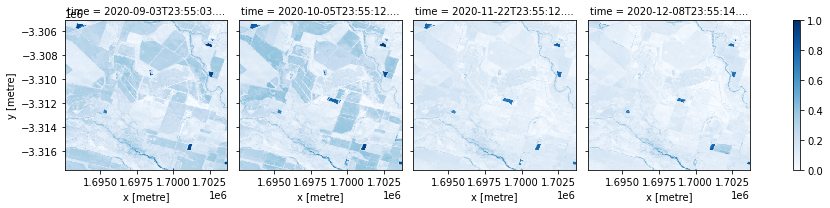

In [12]:
def rmi(ds):
    return np.clip(gvmi(ds) - (0.775 * evi(ds) - 0.0757), 0, 1)

rmi(ds).plot(col='time', col_wrap=4, cmap="Blues")

### 12.- Crop factor kc

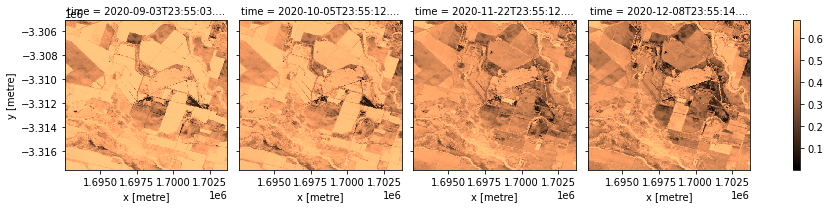

In [13]:
def kc(ds):
    c1 = 0.680
    c2 = -14.12
    c3 = 2.482
    c4 = -7.991
    c5 = 0.890

    return c1 * (1 - np.exp(c2 * np.power(evir(ds), c3) + c4 * np.power(rmi(ds), c5)))

kc(ds).plot(col='time', col_wrap=4, cmap="copper")

### Adding climate variables

### 13.- Potential Evapotranspiration (PET) from BoM online servers

[AWRA BoM page](http://www.bom.gov.au/water/landscape/)

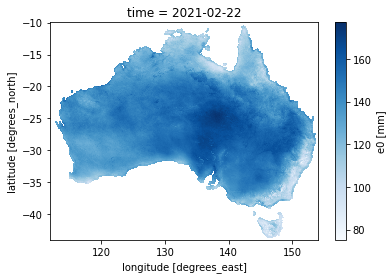

In [14]:
ds_pet = xr.open_dataset("http://www.bom.gov.au/jsp/awra/thredds/dodsC/AWRACMS/values/month/e0.nc", decode_times=False)
base = date(1900, 1, 1)
ds_pet['time'] = [np.datetime64(base + timedelta(days=int(x))) for x in ds_pet.time.values]

ds_pet.e0.isel(time=-1).plot(cmap="Blues")

### 14.- Selecting the grid point corresponding to our location

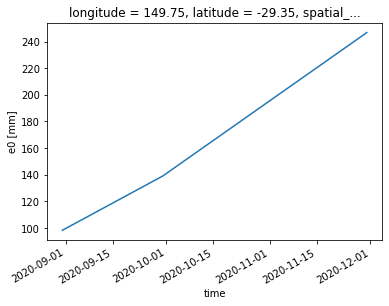

In [15]:
pet = ds_pet.e0.sel(longitude=coords[0], latitude=coords[1], time=ds.time, method="nearest")

pet.plot()

### 15.- Precipitation

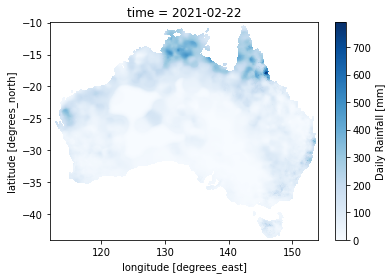

In [16]:
ds_prec = xr.open_dataset("http://www.bom.gov.au/jsp/awra/thredds/dodsC/AWRACMS/values/month/rain_day.nc", decode_times=False)
base = date(1900, 1, 1)
ds_prec['time'] = [np.datetime64(base + timedelta(days=int(x))) for x in ds_prec.time.values]

ds_prec.rain_day.isel(time=-1).plot(cmap="Blues")

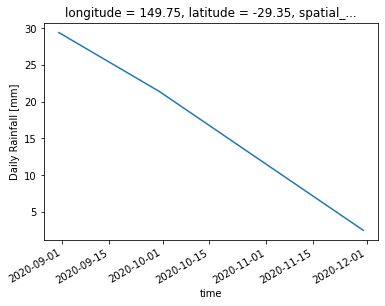

In [17]:
prec = ds_prec.rain_day.sel(longitude=coords[0], latitude=coords[1], time=ds.time, method="nearest")
prec.plot()

### 16.- Finally, lets calculate the Actual Evapotranspiration (AET)

##### AET = kc * PET

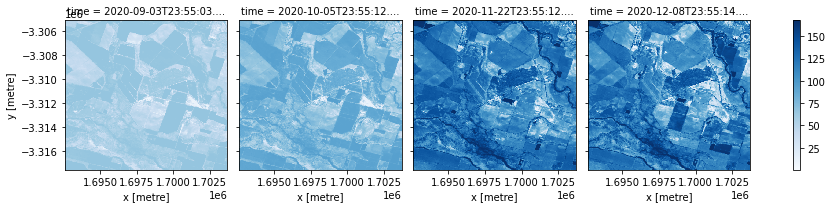

In [18]:
(kc(ds)*pet.values[:,None,None]).plot(col='time', col_wrap=4, cmap="Blues")

### 17.- Plot the temporal evolution over the whole area

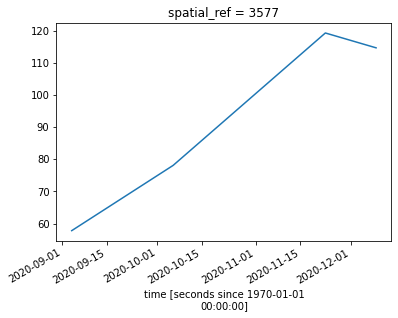

In [19]:
(kc(ds)*pet.values[:,None,None]).mean(dim=["x","y"]).plot()

### 18.- Can you repeat the process for Redbank

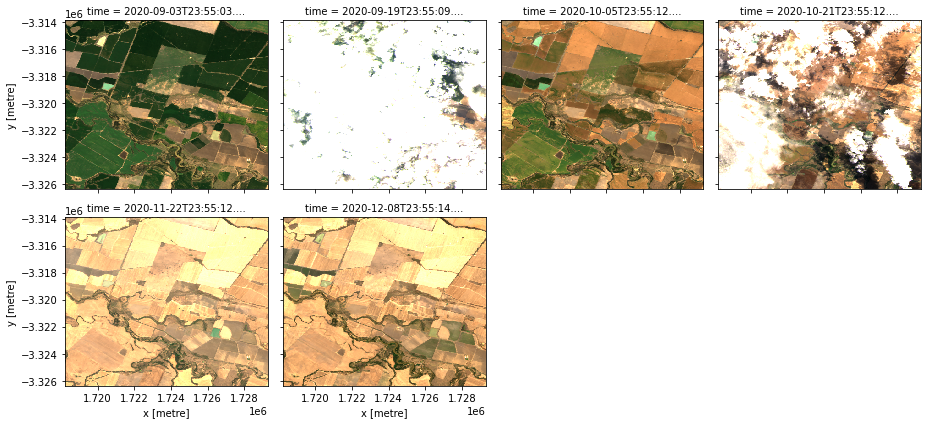

In [21]:
locs = {"Norwood": {"coords": [149.7543738, -29.3741845]},
        "Redbank": {"coords": [150.0313090, -29.4199982]}}

coords = locs["Redbank"]["coords"]

query = {'lat': (coords[1]+0.05, coords[1]-0.05),
         'lon': (coords[0]-0.05, coords[0]+0.05),
         'output_crs': 'EPSG:3577',
         'resolution': (-25, 25),
         'measurements': ['nbart_red', 'nbart_green', 'nbart_blue', 
                          'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'],
         'time':("2020-09-01", "2021-01-01")}

# Scale values between 0-1
ds = dc.load(product='ga_ls8c_ard_3', group_by='solar_day', **query)/10000

ds[['nbart_red','nbart_green','nbart_blue']].clip(0,0.15).to_array().plot.imshow(col='time', col_wrap=4)